# Distributed K-Means

### Authors
- Bezzi Filippo, *2148867*, filippo.bezzi@studenti.unipd.it
- Conte William, *2139490*, william.conte@studenti.unipd.it
- D'Amore Edoardo, *2152861*, edoardo.damore@studenti.unipd.it
- Gasparotto Giacomo, *2156362*, giacomo.gasparotto@studenti.unipd.it

In [11]:
# general imports
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import numpy.typing as npt
import os
import pandas as pd
import seaborn as sns
import time

# pyspark module
from pyspark.rdd import RDD

# src module
from src.data import get_gm, get_kdd
from src.kmeans.base import compute_cost
from src.kmeans.initialization import kMeansParallel_init, kMeansPlusPlus_init, kMeansRandom_init
from src.kmeans.update import lloydKMeans, miniBatchKMeans
from src.utils import sparkSetup

Starting the cluster

In [12]:
# creating the zipped environment if it doesn't already exist
! if [ ! -f "environment.tar.gz" ]; then venv-pack -o "environment.tar.gz" ; fi
# creating the zipped module src
! if [ -f "src.tar.gz" ]; then rm src.tar.gz ; fi
! tar -czf src.tar.gz src

In [13]:
# starting the cluster
! $SPARK_HOME/sbin/start-all.sh

starting org.apache.spark.deploy.master.Master, logging to /usr/local/spark/logs/spark-ubuntu-org.apache.spark.deploy.master.Master-1-mapd-b-14-1.out
worker3: starting org.apache.spark.deploy.worker.Worker, logging to /usr/local/spark/logs/spark-ubuntu-org.apache.spark.deploy.worker.Worker-1-mapd-b-14-4.out
worker2: starting org.apache.spark.deploy.worker.Worker, logging to /usr/local/spark/logs/spark-ubuntu-org.apache.spark.deploy.worker.Worker-1-mapd-b-14-3.out
worker1: starting org.apache.spark.deploy.worker.Worker, logging to /usr/local/spark/logs/spark-ubuntu-org.apache.spark.deploy.worker.Worker-1-mapd-b-14-2.out
master: starting org.apache.spark.deploy.worker.Worker, logging to /usr/local/spark/logs/spark-ubuntu-org.apache.spark.deploy.worker.Worker-1-mapd-b-14-1.out


In [14]:
os.environ["PYSPARK_PYTHON"] = "./environment/bin/python"

In [15]:
# creating a sparkSession
spark = sparkSetup("kMeans")
sc = spark.sparkContext
# exporting the src module
sc.addPyFile("src.tar.gz")
sc.setLogLevel("ERROR")

Description of our computing resources.....

# Datasets

## Gaussian Mixture

The first dataset we would consider to test the performance of the k-means++ initialization algorithm is a synthetic GaussMixture. To generate it, we sampled $k$ centers from a 15-dimensional spherical Gaussian distribution with mean at the origin and variance $R\in \{1,10,100\}$. We then added points from Gaussian distributions of unit variance around each center. Given the $k$ centers, this is a mixture of $k$ spherical Gaussians with equal weights. The value of the optimal k-clustering
can be well approximated using the centers of these Gaussians.

We will perform some preliminary analysis that can be efficiently conducted on this dataset.

## KDD Cup 1999 

The second dataset we want to use to perform our analysis is a real dataset which consists of a collection of simulated network connection data with 41 features and a large number of redundant records, used for training and evaluating intrusion detection systems.

In our case we decided to consider it since it is big enough to study and benchmark distributed computing frameworks. In particular we will use only a $10\%$ of it due to the limited availability of our computing resources.

We performed the following preprocessing operations before working with the dataset:

- Shuffled the dataset;

- Converted the byte entries into floats;

- Scaled the entries using Scikit-learn’s ``StandardScaler()`` (if the standardize parameter was set to True).

# Initialization algorithm analysis - KMeansRandom vs. KMeans++ vs. KMeans||

First of all we will consider only the **Gaussian Mixture** dataset for preliminary analysis.

We will consider three different initialization strategies:

- **Random**, which initialize randomly a certain number of centroids;
- **K-Means++**, selects initial centroids in a smart way, giving higher probability to points that are farther from the already chosen centroids. This reduces the chance of converging to poor solutions compared to completely random initialization;
- **K-Means||**, a distributed version of K-Means++. It works well on very large datasets by selecting multiple candidate centroids in parallel and then refining the final choice.

## Time / Cost tables

The first thing we want to assess is the performance in terms of **time** and **cost** using the aforementioned initialization algorithms:

- **random**;
- **k-means++**;
- **k-means||** with $l\cdot k = 0.5$;
- **k-means||** with $l\cdot k = 2$.

Each of these initialization method is followed by Lloyd's iterations.

This setup allows us to investigate whether the parallelization introduced by the k-means|| initialization leads to improved clustering performance, using random and k-means++ initializations as baselines.

The two metrics we want to compare between the initializations are the execution time, for both the initialization and the update algorithm and the cost which has been calculated as:

$$ C = \frac{1}{|Y|} \sum_{y \in Y} \min_{i=1,\dots,k} \|y - c_i\|^2 $$

where $y$ are our data points and $c_i$ are the actual centroids of the ditribution, normalized on the size of the dataset $|Y|$.

In [16]:
def compute_initAlgoMetrics(
    initAlgo: str,
    data_ndarray: npt.NDArray, 
    data_rdd: RDD, 
    iterations: int, 
    k: int, 
    l: float, 
    r: int
) -> tuple[float, float, float, float]:
    # Initialization
    startTime = time.time()
    
    if initAlgo == "RANDOM": 
        centroids = kMeansRandom_init(data_rdd, k)
    elif initAlgo == "KM++": 
        centroids = kMeansPlusPlus_init(data_ndarray, k)
    elif initAlgo == "KM||": 
        centroids = kMeansParallel_init(data_rdd, k, l, r)
    else: 
        raise ValueError(f"Wrong initialization algorithm selected: '{initAlgo}'")
         
    initTime = time.time() - startTime
    seedCost = compute_cost(data_rdd, centroids)

    # update centroids
    startTime = time.time()
    finalCentroids = lloydKMeans(data_rdd, centroids, iterations)
    updateTime = time.time() - startTime
    finalCost = compute_cost(data_rdd, finalCentroids)
    
    return initTime, updateTime, seedCost, finalCost

Gaussian Mixture dataset creation. The parameters has been chosen according to (Bahmani, Bahman, et al. "Scalable k-means++." arXiv preprint arXiv:1203.6402 (2012).).

In particular, the crucial parameters for dataset creation are:

- k: number of clusters;
- n: number of datapoints;
- dim: dimension of datapoints;
- R: variances of the Gaussian Mixtures.

In [17]:
# --- control parameters ---
k = 50
n = 10_000
dim = 15
R = [1, 10, 100]
r = 5
iterations = 1000
initAlgorithms = ["RANDOM", "KM++", "KM||", "KM||"]
lk_ratios = [0, 0, 0.5, 2]

Creation of a dataframe with the metrics we want to track: 

In [18]:
initAlgoMetrics = []
for variance in R:
    gmData, gmCenters = get_gm(n, k, dim, variance)
    gmData_rdd = sc.parallelize([row for row in gmData], numSlices=16).persist()
    trueCost = compute_cost(gmData_rdd, gmCenters)
    for initAlgo, lk_ratio in zip(initAlgorithms, lk_ratios):
        print(f"R: {variance} | initAlgo: {f"{initAlgo} {lk_ratio}" if initAlgo == "KM||" else initAlgo}")
        initTime, updateTime, seedCost, finalCost = compute_initAlgoMetrics(
            initAlgo = initAlgo,
            data_ndarray = gmData,
            data_rdd = gmData_rdd,
            iterations = iterations,
            k = k,
            l = lk_ratio * k,
            r = r
        )
        initAlgoMetrics.append({
            "R": variance,
            "initAlgo": f"{initAlgo} {lk_ratio}" if initAlgo == "KM||" else initAlgo,
            "initTime": initTime,
            "updateTime": updateTime,
            "seedCost": seedCost,
            "finalCost": finalCost,
            "trueCost": trueCost
        })
    gmData_rdd.unpersist()

initAlgoMetrics = pd.DataFrame(initAlgoMetrics)

R: 1 | initAlgo: RANDOM


R: 1 | initAlgo: KM++


R: 1 | initAlgo: KM|| 0.5


R: 1 | initAlgo: KM|| 2


R: 10 | initAlgo: RANDOM


R: 10 | initAlgo: KM++


R: 10 | initAlgo: KM|| 0.5


R: 10 | initAlgo: KM|| 2


R: 100 | initAlgo: RANDOM


R: 100 | initAlgo: KM++


R: 100 | initAlgo: KM|| 0.5


R: 100 | initAlgo: KM|| 2


Simple visualization of 2/15 dimensions of the dataset.

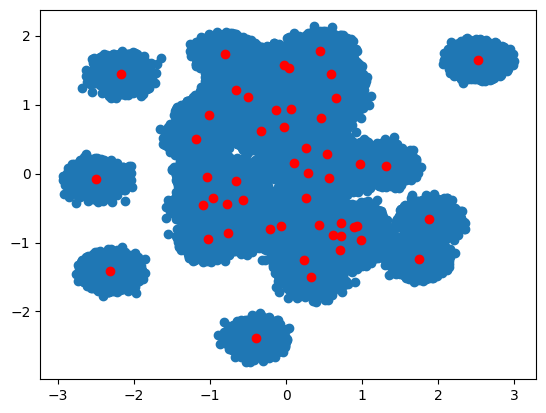

In [21]:
plt.scatter(gmData[:,0], gmData[:,1])
plt.scatter(gmCenters[:,0], gmCenters[:,1], c="red")
plt.show()

The following tables summarize the metrics extracted from the dataset:

In [22]:
initAlgoMetrics[initAlgoMetrics["initAlgo"]=="RANDOM"]

,R,initAlgo,initTime,updateTime,seedCost,finalCost,trueCost
0,1,RANDOM,0.789693,42.816343,12.442790,7.473731,7.443179
4,10,RANDOM,0.505927,15.113345,6.895378,2.625734,1.484280
8,100,RANDOM,0.501441,7.348058,5.778009,2.740502,0.163608


In [23]:
initAlgoMetrics[initAlgoMetrics["initAlgo"]=="KM++"]

,R,initAlgo,initTime,updateTime,seedCost,finalCost,trueCost
1,1,KM++,44.984246,48.077468,12.099102,7.474070,7.443179
5,10,KM++,41.866346,11.807123,4.452820,2.189483,1.484280
9,100,KM++,41.783325,4.572026,0.575064,0.285104,0.163608


In [24]:
initAlgoMetrics[initAlgoMetrics["initAlgo"]=="KM|| 0.5"]

,R,initAlgo,initTime,updateTime,seedCost,finalCost,trueCost
2,1,KM|| 0.5,9.710902,58.951853,10.586996,7.476741,7.443179
6,10,KM|| 0.5,9.583290,22.691981,2.880108,1.939776,1.484280
10,100,KM|| 0.5,9.661565,8.154582,0.744389,0.552951,0.163608


In [25]:
initAlgoMetrics[initAlgoMetrics["initAlgo"]=="KM|| 2"]

,R,initAlgo,initTime,updateTime,seedCost,finalCost,trueCost
3,1,KM|| 2,12.407191,81.625926,8.996282,7.484801,7.443179
7,10,KM|| 2,10.961401,11.296554,2.250755,2.059887,1.484280
11,100,KM|| 2,10.681373,4.547968,0.600562,0.559485,0.163608


A more visual representation is in the following plots:

In [64]:
def plot_initAlgoMetrics(
    initAlgoMetrics: pd.DataFrame,
    dataset: str
) -> None:
    matplotlib.rcParams.update({'font.size': 16})
    
    withTrueCost = "trueCost" in initAlgoMetrics.columns

    # Define metrics, units and titles
    metrics = ["initTime", "updateTime", "seedCost", "finalCost"]
    units = ["time (s)", None, "cost (a.u.)", None]
    titles = ["initTime", "updateTime", "seedCost", "finalCost"]
    if withTrueCost:
        R_values = np.unique(initAlgoMetrics["R"])
        true_costs_dict = {v[0]: v[1] for v in initAlgoMetrics[["R", "trueCost"]].to_numpy()}

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    for ax, metric, title, unit in zip(axs.flat, metrics, titles, units):
        sns.barplot(
            data=initAlgoMetrics,
            x="initAlgo",
            y=metric,
            hue="R" if withTrueCost else None,
            palette="rainbow",
            alpha=0.8,
            ax=ax
        )

        # Plot true cost lines
        if withTrueCost:
            colors = ["purple", "blue", "red"]  
            labels_true = [f"trueCost R={R}" for R in R_values]
            true_handles = [plt.Line2D([0], [0], color=color, linestyle="dashed", linewidth=2, label=label) 
                            for color, label in zip(colors, labels_true)]

            if metric == "finalCost":
                for R, color in zip(R_values, colors):
                    val = true_costs_dict[R]
                    ax.hlines(val, xmin=-0.5, xmax=3.5, linestyle="dashed", color=color)

        ax.set_xlim(-0.5,3.5)
        ax.grid(alpha = 0.5, axis = "y")
        ax.set_xlabel(None, fontsize=16)
        ax.set_ylabel(unit, fontsize=16)
        ax.set_title(title, fontsize=16)
        ax.tick_params(axis="x", labelsize=16)
        ax.tick_params(axis="y", labelsize=16)
        if withTrueCost:
            ax.get_legend().remove()

    time_vals_max = np.max(initAlgoMetrics[["initTime", "updateTime"]])
    cost_vals_max = np.max(initAlgoMetrics[["seedCost", "finalCost"]])
    # y-lims
    for ax in axs[0, :]:
        ax.set_ylim(0, time_vals_max*1.1)
    for ax in axs[1, :]:
        ax.set_ylim(0, cost_vals_max*1.1)

    # Legend
    handles_bar, labels_bar = axs[0,0].get_legend_handles_labels()
    labels_bar = [f"R={lab}" for lab in labels_bar]

    handles = handles_bar + true_handles if withTrueCost else handles_bar
    labels = labels_bar + labels_true if withTrueCost else handles_bar

    fig.legend(
        handles, labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.05),
        ncol=2,
        fontsize=16,
        frameon=False
    )

    plt.savefig(f"{dataset}_time_and_cost_comparison.pdf")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()
    return

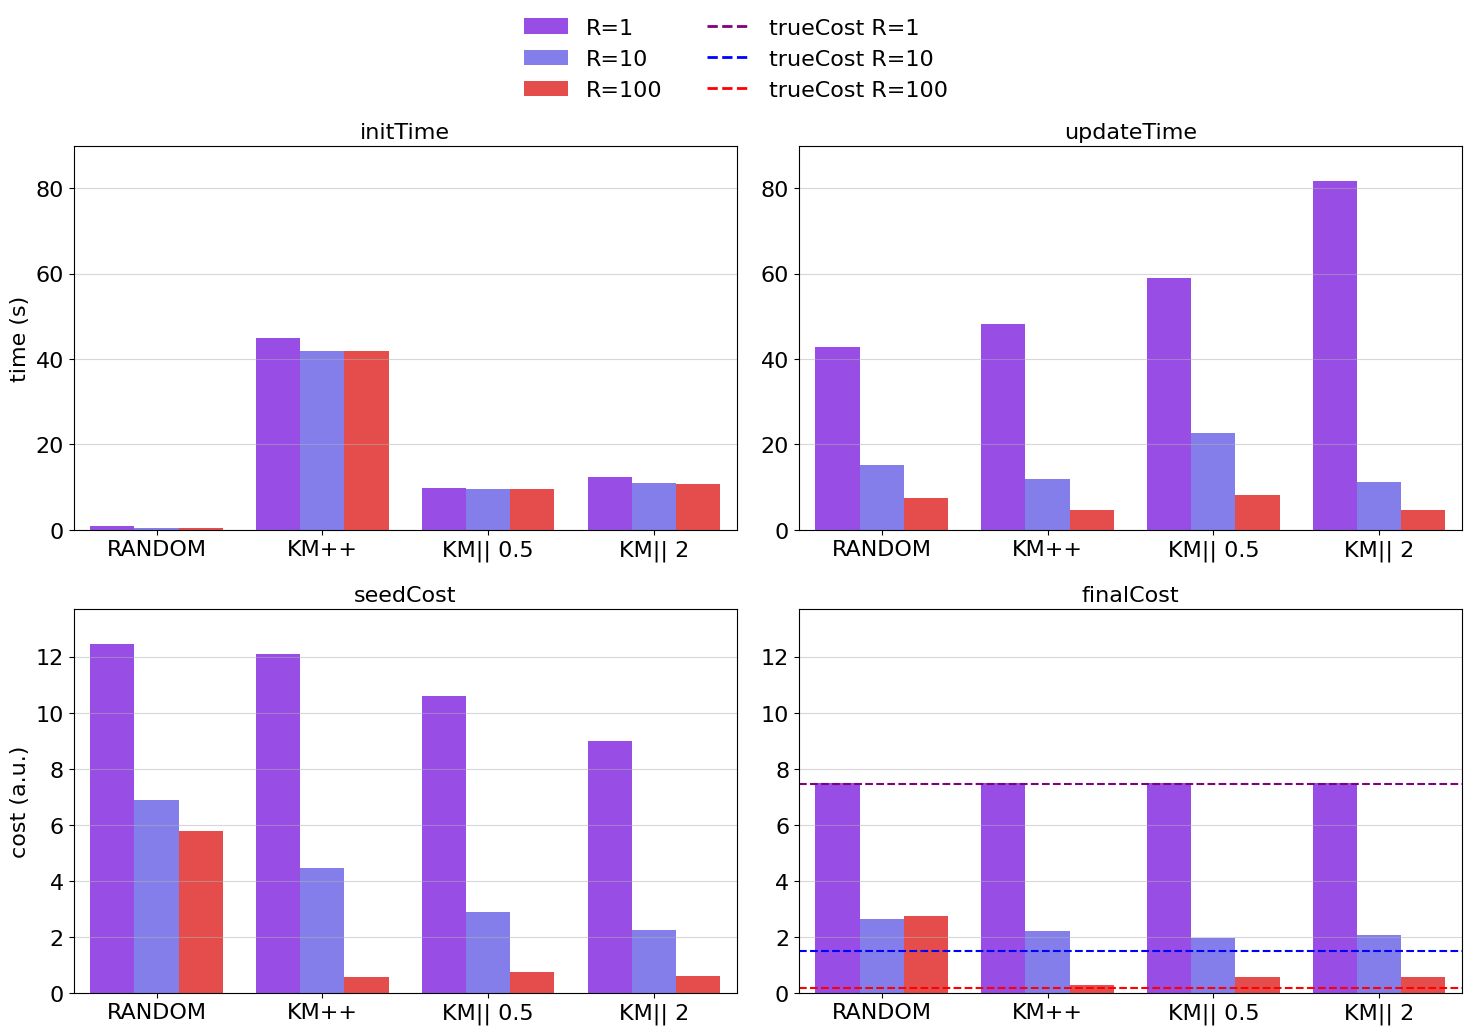

In [50]:
plot_initAlgoMetrics(initAlgoMetrics, "gm")

This plot shows that the parallel implementation of the algorithms provides better results than the serial counterpart both in execution time and in cost.

## Cost vs. r plots

For fixed values of the ratio $l/k$, we aim to test how many rounds $r$ are needed to reach convergence. To do this, we consider only K-Means|| for initialization, since it is the direct parallelization of K-Means++, which has been used as the baseline for comparison.

In [51]:
def collect_costHistory(
    data_rdd: RDD,
    rounds: list[int],
    k: int,
    lk_ratios: list[float],
    iterations: int,
    verbose: bool = False
) -> dict[int, list]:
    costHistory = {}

    for lk_ratio in lk_ratios:
        costHistory[lk_ratio] = []
        for r in rounds:
            if verbose:
                print(f"lk_ratio: {lk_ratio} | rounds: {r}")
            if r==0:
                finalCentroids = kMeansRandom_init(data_rdd, 1)
            else:
                centroids = kMeansParallel_init(data_rdd, k, lk_ratio * k, r)
                finalCentroids = lloydKMeans(data_rdd, centroids, iterations)
            cost = compute_cost(data_rdd, finalCentroids)
            costHistory[lk_ratio].append(cost)
    return costHistory

In [ ]:
# parameters
lk_ratios = [0.5, 1, 2, 5, 10]
rounds = [0, 1, 2, 4, 8, 12, 16]
R = [1, 10, 100]
baselineCosts = []
costHistory = {}
for variance in R:
    print(f"R: {variance}")
    gmData, gmCenters = get_gm(n, k, dim, variance)
    gmData_rdd = sc.parallelize([row for row in gmData], numSlices=16).persist()
    trueCost = compute_cost(gmData_rdd, gmCenters)

    # baseline (KM++ seeds + Lloyd)
    print("KM++")
    centroids = kMeansPlusPlus_init(gmData, k)
    finalCentroids = lloydKMeans(gmData_rdd, centroids, iterations)
    baselineCosts.append(compute_cost(gmData_rdd, finalCentroids))
    
    costHistory[variance] = collect_costHistory(gmData_rdd, rounds, k, lk_ratios, iterations, verbose = True)

R: 10


plusplus


lk_ratio: 0.5 | rounds: 1


lk_ratio: 0.5 | rounds: 2


lk_ratio: 0.5 | rounds: 4


lk_ratio: 0.5 | rounds: 8


lk_ratio: 0.5 | rounds: 16


lk_ratio: 1 | rounds: 1


lk_ratio: 1 | rounds: 2


lk_ratio: 1 | rounds: 4


lk_ratio: 1 | rounds: 8


lk_ratio: 1 | rounds: 16


lk_ratio: 2 | rounds: 1


lk_ratio: 2 | rounds: 2


lk_ratio: 2 | rounds: 4


lk_ratio: 2 | rounds: 8


lk_ratio: 2 | rounds: 16


lk_ratio: 5 | rounds: 1


lk_ratio: 5 | rounds: 2


lk_ratio: 5 | rounds: 4


lk_ratio: 5 | rounds: 8


lk_ratio: 5 | rounds: 16


lk_ratio: 10 | rounds: 1


lk_ratio: 10 | rounds: 2


lk_ratio: 10 | rounds: 4


lk_ratio: 10 | rounds: 8


lk_ratio: 10 | rounds: 16


R: 100
plusplus


lk_ratio: 0.5 | rounds: 1


lk_ratio: 0.5 | rounds: 2


lk_ratio: 0.5 | rounds: 4


lk_ratio: 0.5 | rounds: 8


lk_ratio: 0.5 | rounds: 16


lk_ratio: 1 | rounds: 1


lk_ratio: 1 | rounds: 2


lk_ratio: 1 | rounds: 4


lk_ratio: 1 | rounds: 8


lk_ratio: 1 | rounds: 16


lk_ratio: 2 | rounds: 1


lk_ratio: 2 | rounds: 2


lk_ratio: 2 | rounds: 4


lk_ratio: 2 | rounds: 8


lk_ratio: 2 | rounds: 16


lk_ratio: 5 | rounds: 1


lk_ratio: 5 | rounds: 2


lk_ratio: 5 | rounds: 4


lk_ratio: 5 | rounds: 8


lk_ratio: 5 | rounds: 16


lk_ratio: 10 | rounds: 1


lk_ratio: 10 | rounds: 2


lk_ratio: 10 | rounds: 4


lk_ratio: 10 | rounds: 8


lk_ratio: 10 | rounds: 16


In [52]:
def plot_costHistory(
    costHistory: dict[int, dict[int, list]],
    rounds: list[int],
    baselineCosts: list[float],
    title: str
) -> None:

    matplotlib.rcParams.update({'font.size': 16})
    
    fig, axs = plt.subplots(1, len(costHistory.keys()), figsize=(18, 6), sharey=True)
    if len(costHistory) == 1:
        axs = [axs]  # Ensure axs is iterable

    for idx, (RR, results) in enumerate(costHistory.items()):
        ax = axs[idx]
        
        # Plot baseline
        ax.axhline(baselineCosts[idx], color='k', linestyle='solid', lw=1.5, alpha=0.7, label="KM++ & Lloyd baseline")
        
        # Colormap
        lk_values = results.keys()
        colors = cm.rainbow(np.linspace(0, 1, len(lk_values)))

        # Markers and linestyles
        markers = ["s", "o", "X", "^", "v"]
        lines = ["solid", "dotted", "dashed", "dashdot", "solid"]

        for lk, color, marker, line in zip(lk_values, colors, markers, lines):
            phis = results[lk]
            ax.plot(rounds, phis, marker=marker, markersize=8, markerfacecolor="none",
                    color=color, linewidth=1.5, linestyle=line, alpha=0.8, label=f"l/k={lk}")

        ax.set_title(f"R = {RR}", fontsize=16)
        ax.set_xlabel("# Initialization Rounds", fontsize=16)
        if idx == 0:
            ax.set_ylabel("Cost", fontsize=16)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.legend(frameon=False, fontsize=16)
        ax.grid(alpha=0.6)

    plt.savefig(f"{title}_cost_vs_rounds.pdf")
    plt.tight_layout()
    plt.show()

    return

In [62]:
plot_costHistory(costHistory, rounds, baselineCosts, "gm")

NameError: name 'costHistory' is not defined

From these plots, it is clear that a large value of $r$ is not necessary, as convergence to the baseline is reached around $r \approx 5$. Therefore, for the KDD dataset, we will use a small number of rounds.

### KDD dataset analysis

In [70]:
initAlgorithms = ["RANDOM", "KM++", "KM||", "KM||"]
lk_ratios = [0, 0, 0.5, 2, 10]
r = 5

initAlgoMetrics = []
kddData, kddLabels, entries_dict = get_kdd(standardize=True)
kddData_rdd = sc.parallelize([row for row in kddData], numSlices=16).persist()
k = np.unique(kddLabels).shape[0]
for initAlgo, lk_ratio in zip(initAlgorithms, lk_ratios):
    print(f"initAlgo: {f"{initAlgo} {lk_ratio}" if initAlgo == "KM||" else initAlgo}")
    initTime, updateTime, seedCost, finalCost = compute_initAlgoMetrics(
        initAlgo = initAlgo,
        data_ndarray = kddData,
        data_rdd = kddData_rdd,
        iterations = iterations,
        k = k,
        l = lk_ratio * k,
        r = r
    )
    initAlgoMetrics.append({
        "initAlgo": f"{initAlgo} {lk_ratio}" if initAlgo == "KM||" else initAlgo,
        "initTime": initTime,
        "updateTime": updateTime,
        "seedCost": seedCost,
        "finalCost": finalCost
    })
kddData_rdd.unpersist()

initAlgoMetrics = pd.DataFrame(initAlgoMetrics)

initAlgo: RANDOM


initAlgo: KM++


initAlgo: KM|| 0.5


initAlgo: KM|| 2


/tmp/ipykernel_107618/1605391661.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_107618/1605391661.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_107618/1605391661.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_107618/1605391661.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


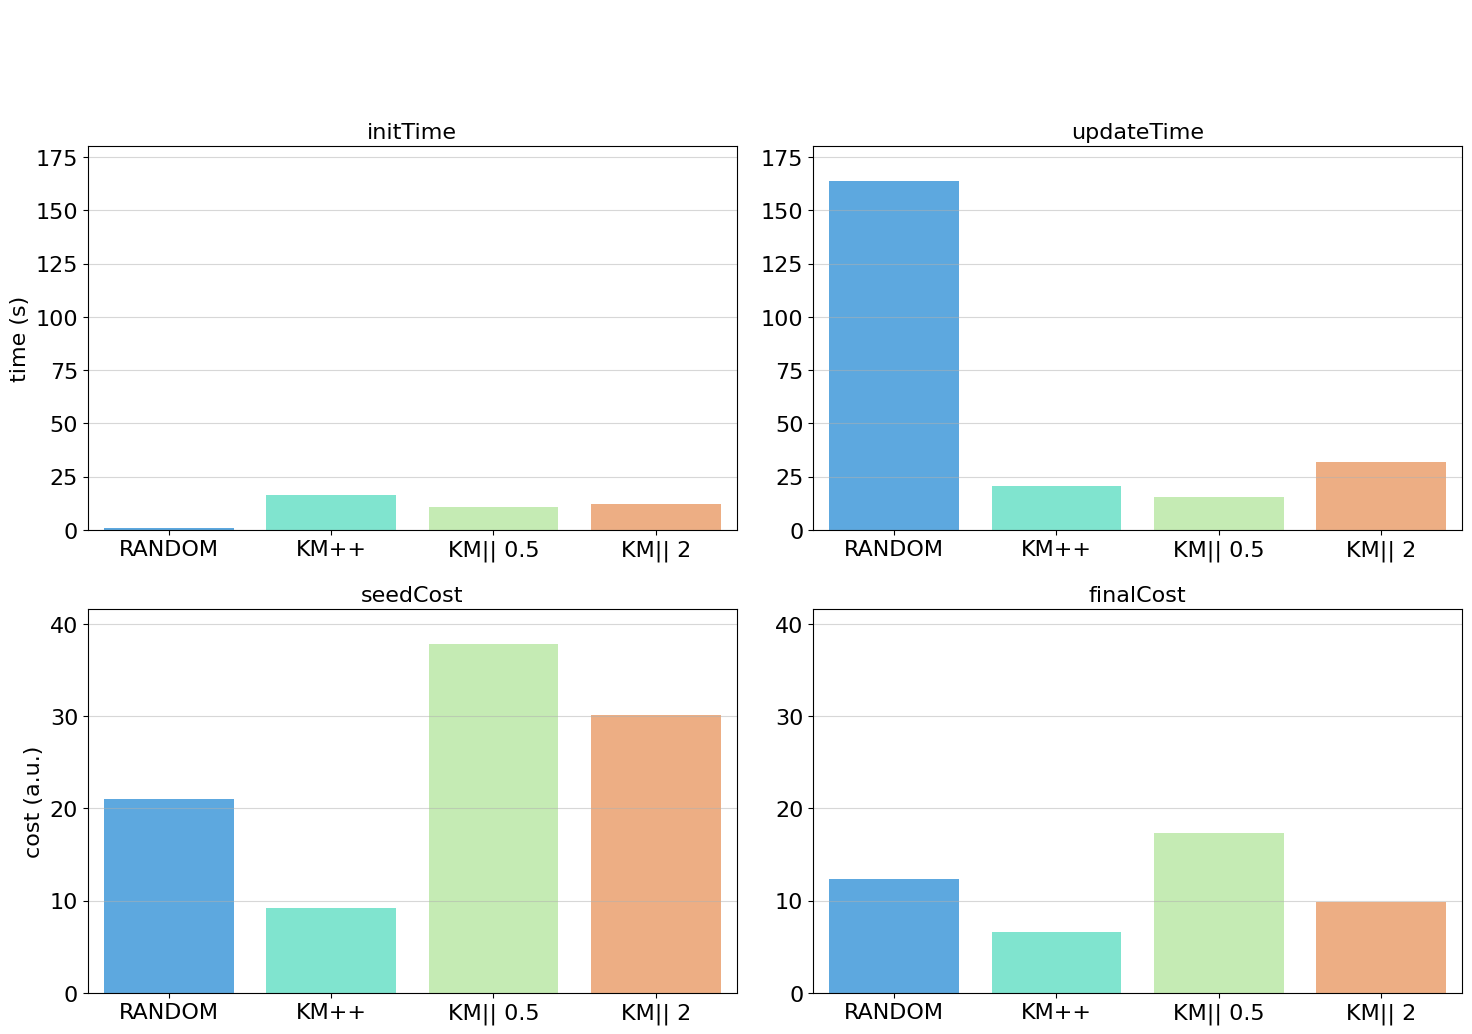

In [72]:
plot_initAlgoMetrics(initAlgoMetrics, "kdd")

In [ ]:
# parameters
lk_ratios = [0.5, 1, 2, 5, 10]
rounds = [0, 1, 2, 4, 8, 12, 16]
R = [1, 10, 100]
baselineCosts = []
costHistory = {}
for variance in R:
    print(f"R: {variance}")
    kddData, kddLabels, entries_dict = get_kdd(standardize=True)
    kddData_rdd = sc.parallelize([row for row in kddData], numSlices=16).persist()

    # baseline (KM++ seeds + Lloyd)
    print("KM++")
    centroids = kMeansPlusPlus_init(kddData, k)
    finalCentroids = lloydKMeans(kddData_rdd, centroids, iterations)
    baselineCosts.append(compute_cost(kddData_rdd, finalCentroids))
    
    costHistory[variance] = collect_costHistory(kddData_rdd, rounds, k, lk_ratios, iterations, verbose = True)

R: 10


plusplus


lk_ratio: 0.5 | rounds: 1


lk_ratio: 0.5 | rounds: 2


lk_ratio: 0.5 | rounds: 4


lk_ratio: 0.5 | rounds: 8


lk_ratio: 0.5 | rounds: 16


lk_ratio: 1 | rounds: 1


lk_ratio: 1 | rounds: 2


lk_ratio: 1 | rounds: 4


lk_ratio: 1 | rounds: 8


lk_ratio: 1 | rounds: 16


lk_ratio: 2 | rounds: 1


lk_ratio: 2 | rounds: 2


lk_ratio: 2 | rounds: 4


lk_ratio: 2 | rounds: 8


lk_ratio: 2 | rounds: 16


lk_ratio: 5 | rounds: 1


lk_ratio: 5 | rounds: 2


lk_ratio: 5 | rounds: 4


lk_ratio: 5 | rounds: 8


lk_ratio: 5 | rounds: 16


lk_ratio: 10 | rounds: 1


lk_ratio: 10 | rounds: 2


lk_ratio: 10 | rounds: 4


lk_ratio: 10 | rounds: 8


lk_ratio: 10 | rounds: 16


R: 100
plusplus


lk_ratio: 0.5 | rounds: 1


lk_ratio: 0.5 | rounds: 2


lk_ratio: 0.5 | rounds: 4


lk_ratio: 0.5 | rounds: 8


lk_ratio: 0.5 | rounds: 16


lk_ratio: 1 | rounds: 1


lk_ratio: 1 | rounds: 2


lk_ratio: 1 | rounds: 4


lk_ratio: 1 | rounds: 8


lk_ratio: 1 | rounds: 16


lk_ratio: 2 | rounds: 1


lk_ratio: 2 | rounds: 2


lk_ratio: 2 | rounds: 4


lk_ratio: 2 | rounds: 8


lk_ratio: 2 | rounds: 16


lk_ratio: 5 | rounds: 1


lk_ratio: 5 | rounds: 2


lk_ratio: 5 | rounds: 4


lk_ratio: 5 | rounds: 8


lk_ratio: 5 | rounds: 16


lk_ratio: 10 | rounds: 1


lk_ratio: 10 | rounds: 2


lk_ratio: 10 | rounds: 4


lk_ratio: 10 | rounds: 8


lk_ratio: 10 | rounds: 16


# Update analysis - lloydKMeans vs. miniBatchKMeans

## time vs. partitions

In [7]:
kddData, kddLabels, entries_dict = get_kdd(standardize=True)

In [ ]:
k = np.unique(kddLabels).shape[0]
l = 10 * k

In [9]:
kddData_rdd = sc.parallelize([row for row in kddData]).persist()
centroids = kMeansParallel_init(kddData_rdd, k, l)
kddData_rdd.unpersist()

ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:289

In [9]:
time_dict = {}

Lloyd's kMeans serial

In [10]:
iterations = 10
startTime = time.time()
seedCentroids = centroids.copy()
finalCentroids = lloydKMeans(kddData, seedCentroids, iterations, earlyStopping=False)
deltaTime = time.time() - startTime
time_dict[1] = {"lloyd": deltaTime}

Parallel

In [11]:
partitions = [2, 4, 8, 16, 32, 64, 128, 256]
for numSlices in partitions:
    time_dict[numSlices] = {}
    startTime = time.time()
    kddData_rdd = sc.parallelize([row for row in kddData], numSlices=numSlices).persist()
    kddData_rdd.count()
    deltaTime = time.time() - startTime
    time_dict[numSlices]["caching"] = deltaTime
    
    startTime = time.time()
    seedCentroids = centroids.copy()
    finalCentroids = lloydKMeans(kddData_rdd, seedCentroids, iterations, earlyStopping=False)
    deltaTime = time.time() - startTime
    time_dict[numSlices]["lloyd"] = deltaTime

    startTime = time.time()
    seedCentroids = centroids.copy()
    finalCentroids = miniBatchKMeans(kddData_rdd, seedCentroids, iterations, earlyStopping=False)
    deltaTime = time.time() - startTime
    time_dict[numSlices]["miniBatch"] = deltaTime
    
    kddData_rdd.unpersist()

In [12]:
time_dict

{1: {'lloyd': 16.14174199104309},
 2: {'caching': 3.2530412673950195,
  'lloyd': 30.405675411224365,
  'miniBatch': 12.193506002426147},
 4: {'caching': 2.8967554569244385,
  'lloyd': 18.112455129623413,
  'miniBatch': 8.33168649673462},
 8: {'caching': 2.742198944091797,
  'lloyd': 11.270909309387207,
  'miniBatch': 6.004958152770996},
 16: {'caching': 2.6079213619232178,
  'lloyd': 8.476496696472168,
  'miniBatch': 5.604610443115234},
 32: {'caching': 2.7402966022491455,
  'lloyd': 10.348712921142578,
  'miniBatch': 6.531096935272217},
 64: {'caching': 2.732876777648926,
  'lloyd': 12.216644287109375,
  'miniBatch': 9.318732261657715},
 128: {'caching': 3.1213254928588867,
  'lloyd': 17.25415062904358,
  'miniBatch': 14.518196105957031},
 256: {'caching': 3.860670328140259,
  'lloyd': 26.667199850082397,
  'miniBatch': 23.39391016960144}}

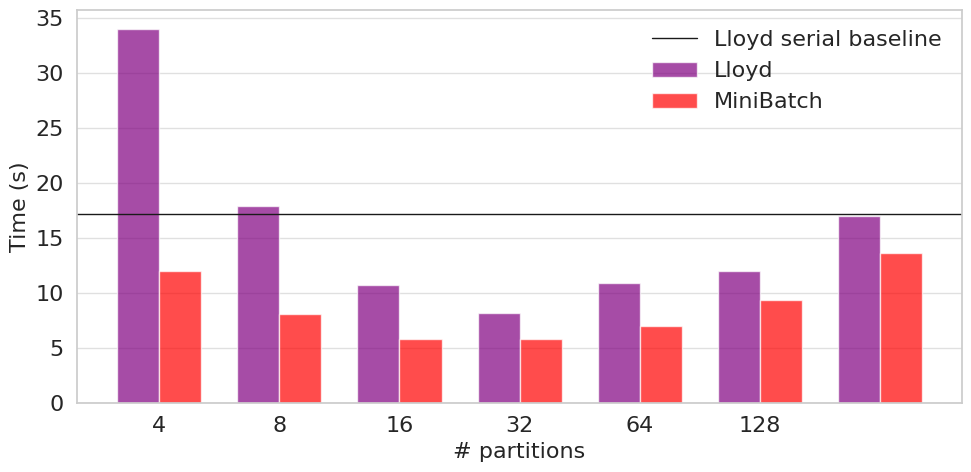

In [ ]:
# Partition vs time plot
keys = [k for k in time_dict.keys() if k != 1] 
lloyd_values = [time_dict[k]['lloyd'] for k in keys]
minibatch_values = [time_dict[k]['miniBatch'] for k in keys]

x = np.arange(len(keys))

matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10, 5))

width = 0.35
ax.bar(x - width/2, lloyd_values, 0.35, label='Lloyd', color="purple", alpha=0.7)
ax.bar(x + width/2, minibatch_values, 0.35, label='MiniBatch', color="red", alpha=0.7)

# Baseline
ax.axhline(time_dict[1]['lloyd'], color='k', linestyle="--", linewidth=1, label="Lloyd serial baseline")

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_xticklabels(keys)
ax.set_xlabel("# partitions", fontsize=16)
ax.set_ylabel("Time (s)", fontsize=16)
ax.legend(frameon=False, fontsize=16)

plt.grid(None)
ax.grid(axis="y", alpha=0.6)

plt.savefig("partition_plot.pdf")
plt.tight_layout()
plt.show()

### Cost vs iterations


We now want to study, for each version of the algorithm, the number of iterations required to obtain an optimal solution. To do this, we track the cost function values at each iteration:

In [ ]:
kddData_rdd = sc.parallelize([row for row in kddData], numSlices=16).persist()
iterations = 50
updateAlgorithms = ["lloyd", "lloyd", "miniBatch", "miniBatch", "miniBatch", "miniBatch"]
batchFractions = ["serial", "parallel", 0.001, 0.01, 0.1, 0.5]

results_dict = {}

seedCost = compute_cost(kddData_rdd, centroids)

# n_runs = 3  # number of independent runs
for updateAlgo, batchFraction in zip(updateAlgorithms, batchFractions):
    print(f"{updateAlgo}_{batchFraction}")
    seedCentroids = centroids.copy()

    if updateAlgo == "lloyd":
        if batchFraction == "serial":
            finalCentroids, costHistory = lloydKMeans(kddData, seedCentroids, iterations, save_cost = True, earlyStopping = False)
        else:
            finalCentroids, costHistory = lloydKMeans(kddData_rdd, seedCentroids, iterations, save_cost = True, earlyStopping = False)
    else:
        finalCentroids, costHistory = miniBatchKMeans(kddData_rdd, seedCentroids, iterations, batchFraction, save_cost = True, earlyStopping = False)

    results_dict[f"{updateAlgo}_{batchFraction}"] = costHistory
kddData_rdd.unpersist()

lloyd_serial
lloyd_parallel


miniBatch_0.001


miniBatch_0.01


miniBatch_0.1


miniBatch_0.5


ParallelCollectionRDD[60] at readRDDFromFile at PythonRDD.scala:289

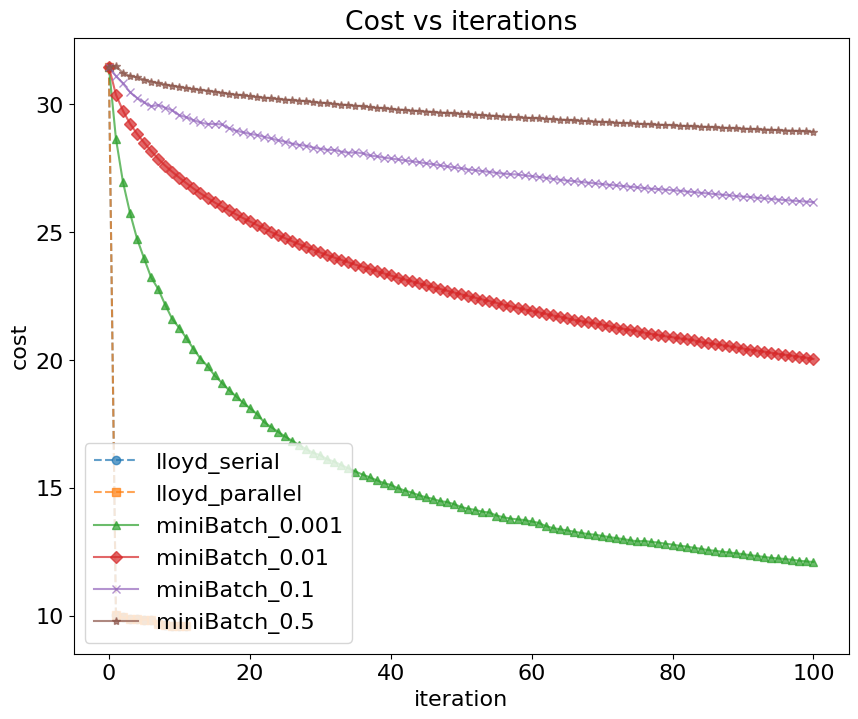

In [11]:
matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10,8))
markers = ['o', 's', '^', 'D', 'x', '*']

for i, (key, costHistory) in enumerate(results_dict.items()):
    
    if "lloyd" in key:
        line_style = "--"   
    else:
        line_style = "-"

    ax.plot([seedCost] + costHistory, marker=markers[i], label = key, linestyle = line_style, alpha = 0.7)
    

ax.set_title("Cost vs iterations")
ax.set_xlabel("iteration")
ax.set_ylabel("cost")
ax.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

# different markers
markers = ['o', 's', '^', 'D', 'x', '*']

# offsets to avoid errorbar overlaps
offsets = [0,1,0,0,1,-1]
for i, (key, stats) in enumerate(results_mean_std.items()):
    mean = stats["mean"]
    std = stats["std"]
    epochs = np.arange(len(mean))

    # line style
    if "lloyd" in key:
        line_style = "--"   
    else:
        line_style = "-"    

    # cycle markers
    marker = markers[i]
    
    plt.errorbar(
        epochs[::10+offsets[i]], mean[::10+offsets[i]], yerr=std[::10+offsets[i]],
        fmt=line_style+marker, capsize=3, label=key
    )
    offset += 1

plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Cost", fontsize=14)
plt.title("K-Means Convergence: Cost vs Epochs", fontsize=16)
plt.grid(alpha=0.6)
plt.legend(title="Algorithm:", loc="best")
plt.show()

From the plot above, we observe an interesting pattern: although the serial and parallel K-means algorithms require fewer iterations to reach convergence, they also demand more execution time. In contrast, the minibatch version requires more iterations to converge but achieves a lower overall execution time.

Another interesting observation is that better solutions for the minibatch algorithm, in terms of minimizing the cost function, are obtained when using smaller batch fractions.  
This can be explained by the formula used to update a generic centroid $j$:

$$
c_j^{(t+1)} = (1 - \eta_t) \, c_j^{(t)} + \eta_t \, \bar{x}_j^{(t)}
$$

where $\eta_t$ is the learning rate used for the update of centroid $j$ at iteration $t$.  
The learning rate is proportional to $\frac{1}{N_j^{\text{samples}}}$, where $N_j^{\text{samples}}$ is the total number of points assigned to cluster $j$ since the beginning of the algorithm.  

From this formula, we see that larger batch fractions result in a faster increase of $N_j^{\text{samples}}$, which in turn reduces the learning rate more quickly.  
Consequently, the centroid updates become smaller over time, potentially leading to slower convergence and poorer minimization of the cost function. Note that the parallel K-means update formula can be recovered from the expression above by setting the learning rate to a constant value of 1.

Stopping the cluster

In [73]:
sc.stop()
spark.stop()

In [74]:
# stopping the cluster
! $SPARK_HOME/sbin/stop-all.sh
# clearing the `$SPARK_HOME/work` directory in all the nodes
# this avoids cluttering of storage among nodes
! rm -rf $SPARK_HOME/work/*
! ssh worker1 "rm -rf $SPARK_HOME/work/*"
! ssh worker2 "rm -rf $SPARK_HOME/work/*"
! ssh worker3 "rm -rf $SPARK_HOME/work/*"

worker3: stopping org.apache.spark.deploy.worker.Worker
worker1: stopping org.apache.spark.deploy.worker.Worker
worker2: stopping org.apache.spark.deploy.worker.Worker
master: stopping org.apache.spark.deploy.worker.Worker
stopping org.apache.spark.deploy.master.Master
